In [11]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "scripts"))
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
%load_ext autoreload
%autoreload 2
from core_functions import load_and_prepare_potentials, integratorV
from simulation import VesicleSimulator
from image_processing import process_image, radial_intensity_profile, center_and_pad_profile
from analysis import analyze_profiles_from_csv
from plotting import plot_phase_shifts, plot_integration_profiles, save_tiff_and_plot

print("Modules imported successfully.")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules imported successfully.


In [3]:
# inputs, outputs and parameters
 
AP_PATH = "input/ndp_cut.dat"  # element potentials
DP_PATH = "input/dipole.dat"  # dipole potentials
INTEGRATION_CACHE_FILE = 'bilayer_projection.json' # integrated projection file name, change name if generating new file or keep same to use previously genrated file
IMAGE_OUTPUT_DIR = "noisy_images" # where the final images with noise are produced and also directory for analysis
os.makedirs(IMAGE_OUTPUT_DIR, exist_ok=True)
OUTPUT_DIRS = {"related": "related_images", "noise_free": "noise_free"}
os.makedirs(OUTPUT_DIRS["related"], exist_ok=True)
os.makedirs(OUTPUT_DIRS["noise_free"], exist_ok=True)

ANGSTROM_PER_PIXEL = 2.7
VESICLE_SIZES = np.arange(30, 130, 10) # (start diameter, end diameter - interval, interval) in nm
defocus = 2 # in μm
accelarating_voltage = 300 # in kV
SIMULATION_PARAMS = {"I0": 880, "kev": accelarating_voltage, "delta_z": defocus, "m": 400, "Q": 0.075, "B": 300}
ADD_STRUCTURAL_NOISE = False  # Set to False to disable
STRUCTURAL_NOISE_STD = 0.1
NOISY_NUM = 1 # number of noisy images to generate for each size
Scaling_Factor_img = 2.5 # control pixel intensity
Stddev_Noise_img = 200 # control noise deviation
intensity_profile_smoothing = 3 # control smoothing of intensity profile
SHOW_PLOTS = True  # Set to False to hide plots

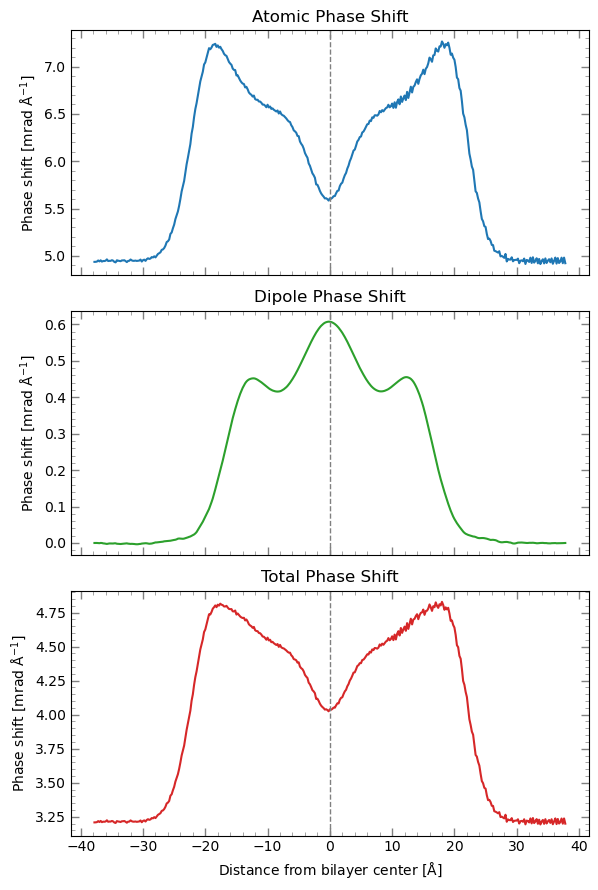

Loading pre-computed integrations from 'bilayer_projection.json'.


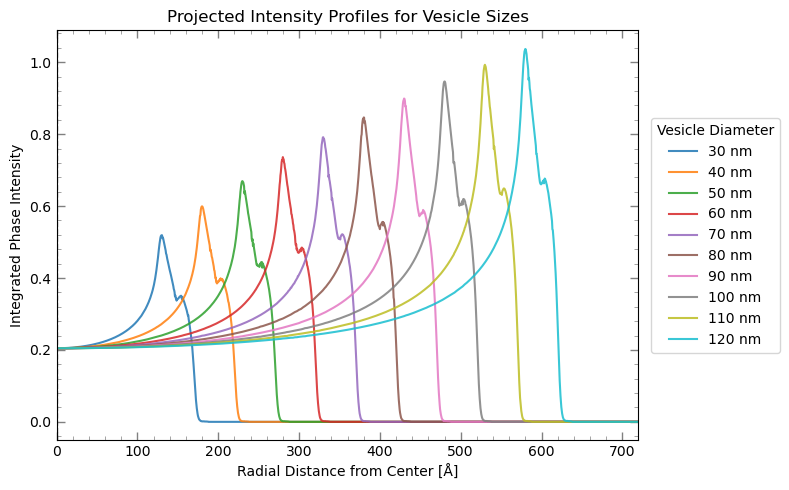

--- Generating and saving all noise-free images ---
✅ All noise-free images generated and saved in 'noise_free/'


In [4]:
zVals, total_AP, DP, total_phase_shift = load_and_prepare_potentials(AP_PATH, DP_PATH)
plot_phase_shifts(zVals, total_AP, DP, total_phase_shift, show_plot=SHOW_PLOTS)

if os.path.exists(INTEGRATION_CACHE_FILE):
    print(f"Loading pre-computed integrations from '{INTEGRATION_CACHE_FILE}'.")
    with open(INTEGRATION_CACHE_FILE, 'r') as f:
        integrations = json.load(f)
else:
    print(f"Calculating integrations for vesicle sizes...")
    integrations = [
        integratorV(zVals, total_phase_shift, rd, rEnd=VESICLE_SIZES[-1]*5 + 150, rstep=0.5)
        for rd in VESICLE_SIZES * 5  # Convert nm diameter to angstrom radius
    ]
    with open(INTEGRATION_CACHE_FILE, 'w') as f:
        json.dump(integrations, f)
    print(f"Integrations saved to '{INTEGRATION_CACHE_FILE}'.")

# --- Visualize the projected profiles ---
plot_integration_profiles(integrations, VESICLE_SIZES,show_plot=SHOW_PLOTS)

# Scale projection data from Angstroms to pixels
scaled_data = [
    [[x / ANGSTROM_PER_PIXEL for x in entry[0]], entry[1]]
    for entry in integrations
]
vesicle_index_map = {size: i for i, size in enumerate(VESICLE_SIZES)}

print("--- Generating and saving all noise-free images ---")
for vesicle_nm in VESICLE_SIZES:
    data_index = vesicle_index_map[vesicle_nm]
    
    sim = VesicleSimulator(scaled_data[1], SIMULATION_PARAMS, ANGSTROM_PER_PIXEL, add_structural_noise=ADD_STRUCTURAL_NOISE, 
                           structural_noise_std=STRUCTURAL_NOISE_STD)
    
    for i in range(1):
        noise_free_img = sim.get_noisefree_image(scaling_factor=Scaling_Factor_img)
        
        filename = os.path.join(OUTPUT_DIRS["noise_free"], f"{vesicle_nm}nm_img{i+1}.tiff")
        tiff.imwrite(filename, noise_free_img.astype(np.float32))
        
print(f"✅ All noise-free images generated and saved in '{OUTPUT_DIRS['noise_free']}/'")

--- Generating diagnostic images ---
✅ Image saved to 'related_images/projection.tiff'


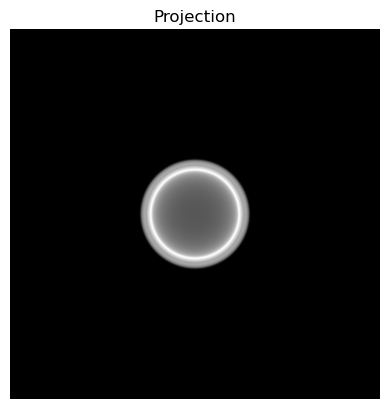

✅ Image saved to 'related_images/fft.tiff'


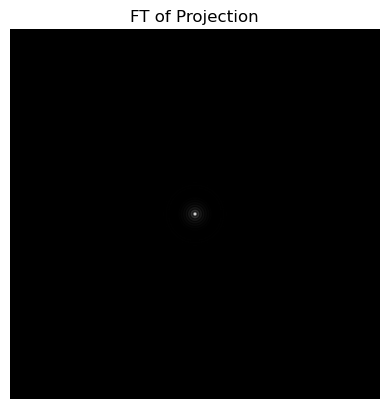

✅ Image saved to 'related_images/fft_ctf.tiff'


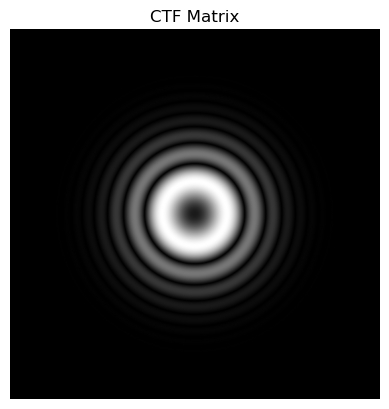

✅ Image saved to 'related_images/noise_free.tiff'


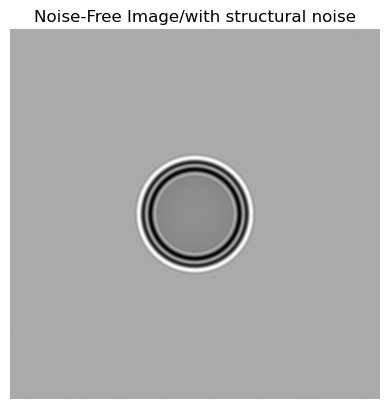

In [5]:
print("--- Generating diagnostic images ---")
# Use data for a 40nm vesicle (index 1)
# UPDATE CALL HERE
diagnostic_sim = VesicleSimulator(scaled_data[1], SIMULATION_PARAMS, ANGSTROM_PER_PIXEL, add_structural_noise=ADD_STRUCTURAL_NOISE, 
structural_noise_std=STRUCTURAL_NOISE_STD)

proj_img = diagnostic_sim.get_projection_image()
save_tiff_and_plot(proj_img, os.path.join(OUTPUT_DIRS["related"], "projection.tiff"), "Projection", show_plot=SHOW_PLOTS)
fft_img = diagnostic_sim.get_fft_image()
save_tiff_and_plot(fft_img, os.path.join(OUTPUT_DIRS["related"], "fft.tiff"), "FT of Projection", show_plot=SHOW_PLOTS)
ctf_img = diagnostic_sim.get_ctf_image()
save_tiff_and_plot(ctf_img, os.path.join(OUTPUT_DIRS["related"], "fft_ctf.tiff"), "CTF Matrix", show_plot=SHOW_PLOTS)

noise_free_img = diagnostic_sim.get_noisefree_image(scaling_factor=Scaling_Factor_img)
save_tiff_and_plot(noise_free_img, os.path.join(OUTPUT_DIRS["related"], "noise_free.tiff"), "Noise-Free Image/with structural noise", show_plot=SHOW_PLOTS)

In [6]:
print("--- Generating noisy images ---")
for vesicle_nm in VESICLE_SIZES:
    data_index = vesicle_index_map[vesicle_nm]
    
    # UPDATE CALL HERE INSIDE LOOP
    sim = VesicleSimulator( scaled_data[data_index], SIMULATION_PARAMS, ANGSTROM_PER_PIXEL,
        add_structural_noise=ADD_STRUCTURAL_NOISE, structural_noise_std=STRUCTURAL_NOISE_STD)
    
    print(f"Generating images for {vesicle_nm}nm vesicle...")
    for i in range(NOISY_NUM):
        noisy_img = sim.get_noisy_image(scaling_factor=Scaling_Factor_img, stddev=Stddev_Noise_img)
        filename = os.path.join(IMAGE_OUTPUT_DIR, f"{vesicle_nm}nm_img{i+1}.tiff")
        tiff.imwrite(filename, noisy_img.astype(np.float32))
        
print("✅ All noisy images generated.")

--- Generating noisy images ---
Generating images for 30nm vesicle...
Generating images for 40nm vesicle...
Generating images for 50nm vesicle...
Generating images for 60nm vesicle...
Generating images for 70nm vesicle...
Generating images for 80nm vesicle...
Generating images for 90nm vesicle...
Generating images for 100nm vesicle...
Generating images for 110nm vesicle...
Generating images for 120nm vesicle...
✅ All noisy images generated.


In [7]:
centered_profiles = []
img_files = sorted([f for f in os.listdir(IMAGE_OUTPUT_DIR) if f.endswith(".tiff")])

print("--- Processing generated images to extract radial profiles ---")
for filename in img_files:
    img, cx, cy, r1, r2, pixel_radius = process_image(filename, IMAGE_OUTPUT_DIR, ANGSTROM_PER_PIXEL)
    radii, intensities = radial_intensity_profile(img, cx, cy, r1, r2, ANGSTROM_PER_PIXEL, smooth_sigma=intensity_profile_smoothing)
    radii_nm = (radii - pixel_radius) * ANGSTROM_PER_PIXEL
    shifted_radii, shifted_intensities = center_and_pad_profile(radii_nm, intensities)
    centered_profiles.append({"filename": filename, "distance": shifted_radii, "intensities": shifted_intensities})

print(f"Processed {len(centered_profiles)} images.")

--- Processing generated images to extract radial profiles ---
Processed 10 images.


In [8]:
# Create and save a DataFrame of all profiles
PROFILE_CSV_PATH = "results/centered_profiles_wide.csv"
data_dict = {'distance': centered_profiles[0]['distance']}
for profile in centered_profiles:
    data_dict[profile['filename']] = profile['intensities']
df_cp = pd.DataFrame(data_dict)
df_cp.to_csv(PROFILE_CSV_PATH, index=False)
print(f"Centered profiles saved to '{PROFILE_CSV_PATH}'")

# Run the final analysis on the profiles
ANALYSIS_CSV_PATH = "results/profile_analysis_result.csv"
df_analysis = analyze_profiles_from_csv(PROFILE_CSV_PATH)
df_analysis.to_csv(ANALYSIS_CSV_PATH, index=False)
print(f"Final analysis saved to '{ANALYSIS_CSV_PATH}'")

Centered profiles saved to 'results/centered_profiles_wide.csv'
Final analysis saved to 'results/profile_analysis_result.csv'


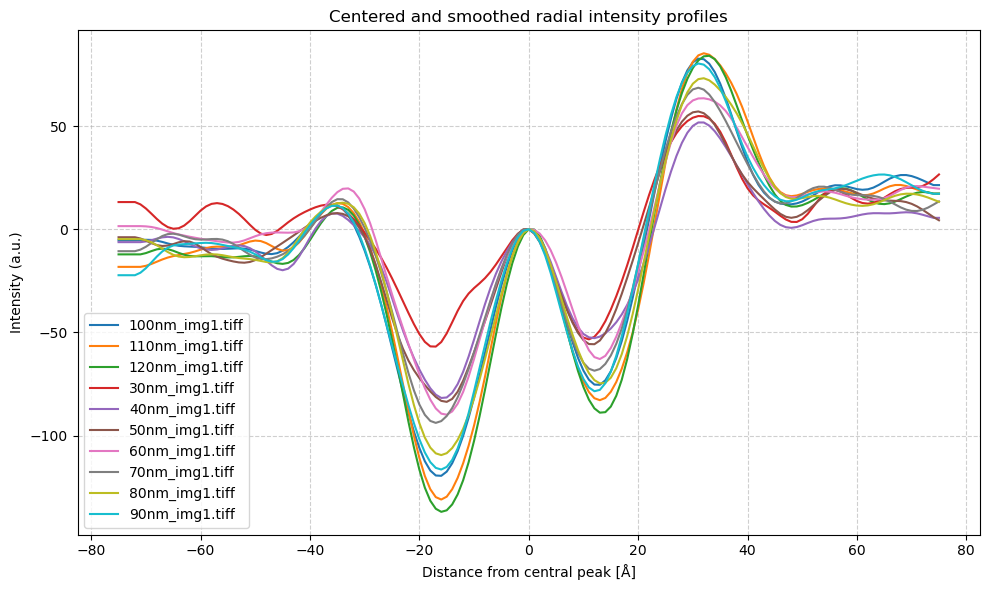

In [9]:
plt.figure(figsize=(10, 6))
for d in centered_profiles :
    plt.plot(d['distance'], d['intensities'], label=d['filename'])

# Label and style
plt.title('Centered and smoothed radial intensity profiles')
plt.xlabel('Distance from central peak [Å]')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()


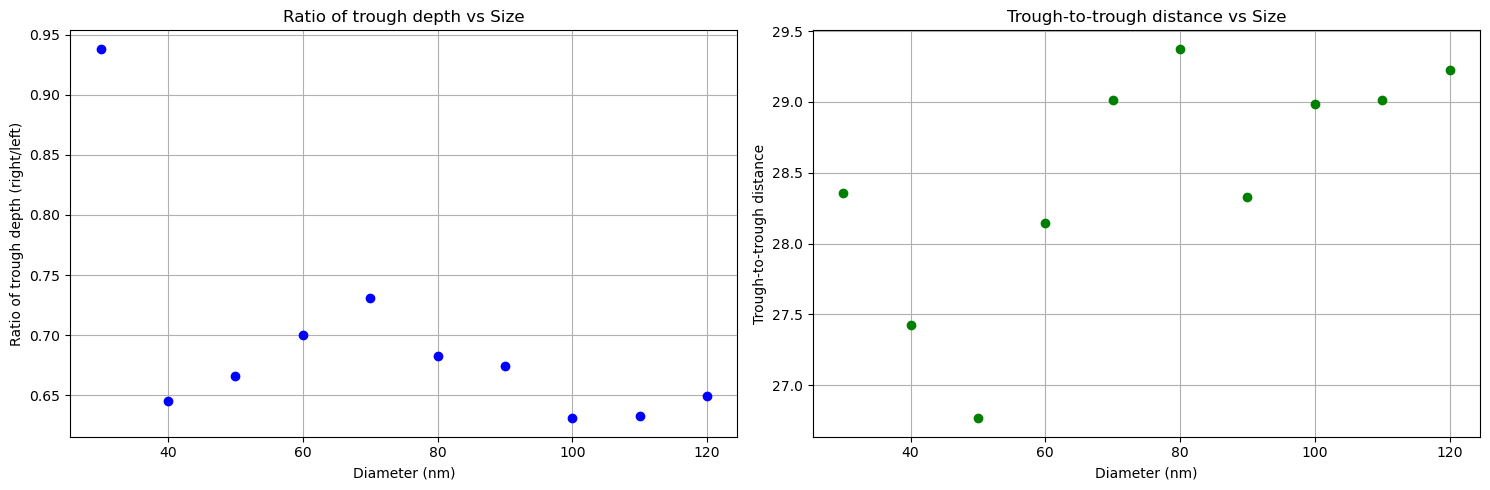

In [10]:
x = df_analysis['size_nm']
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(x, df_analysis['ratio_minima'], 'o', color='blue')
plt.xlabel("Diameter (nm)")
plt.ylabel("Ratio of trough depth (right/left)")
plt.title("Ratio of trough depth vs Size")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, df_analysis['min_distance'], 'o', color='green')
plt.xlabel("Diameter (nm)")
plt.ylabel("Trough-to-trough distance")
plt.title("Trough-to-trough distance vs Size")
plt.grid(True)

plt.tight_layout()
plt.show()